In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory 

In [2]:
## Get Directories
dir = r'./autism_dataset/'
train_dir = os.path.join(dir,'train')
test_dir = os.path.join(dir,'test')
val_dir = os.path.join(dir,'valid')

In [3]:
## Define Image size and Batch size 
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

print(BATCH_SIZE)

32


In [4]:
## Creates datasets
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

valid_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2538 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


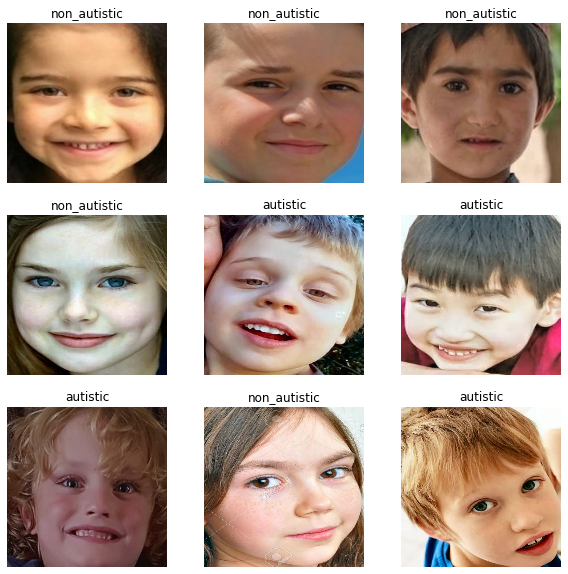

In [5]:
## Show first Classes
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
## Autotune 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
## Create the base model with pre-trained model MobileNetV2 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
print(IMG_SHAPE)

(160, 160, 3)


In [8]:
 ## Feature Extraction

In [9]:
## freeze pre-trained model weights 
base_model.trainable = False

In [10]:
## Normalisation
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
data_augmentation = tf.keras.Sequential([
    #augmentation
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [12]:
## Add classification head
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [19]:
## Add prediction Layer 
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [20]:
# Model creation
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
## Compile 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [23]:
## Train Model with validation dataset
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valid_dataset)

7/7 [==============================] - 7s 535ms/step - loss: 0.8746 - accuracy: 0.4950


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/10
80/80 [==============================] - 110s 1s/step - loss: 0.7185 - accuracy: 0.5567 - val_loss: 0.6792 - val_accuracy: 0.5200
Epoch 2/10
80/80 [==============================] - 60s 741ms/step - loss: 0.6939 - accuracy: 0.5757 - val_loss: 0.6638 - val_accuracy: 0.5650
Epoch 3/10
80/80 [==============================] - 65s 808ms/step - loss: 0.6530 - accuracy: 0.6162 - val_loss: 0.6528 - val_accuracy: 0.5900
Epoch 4/10
80/80 [==============================] - 77s 957ms/step - loss: 0.6508 - accuracy: 0.6288 - val_loss: 0.6446 - val_accuracy: 0.6250
Epoch 5/10
80/80 [==============================] - 72s 886ms/step - loss: 0.6315 - accuracy: 0.6391 - val_loss: 0.6363 - val_accuracy: 0.6250
Epoch 6/10
80/80 [==============================] - 62s 764ms/step - loss: 0.6162 - accuracy: 0.6596 - val_loss: 0.6295 - val_accuracy: 0.6400
Epoch 7/10
80/80 [==============================] - 58s 713ms/step - loss: 0.5949 - accuracy: 0.6588 - val_loss: 0.6239 - val_accuracy: 0.6450
E

Mean Validation Accuracy: 0.6730952291261583
Mean Training Accuracy:0.7055048970949083
Mean Validation Loss: 0.5748897209053948
Mean Training Loss:0.5416049318654197


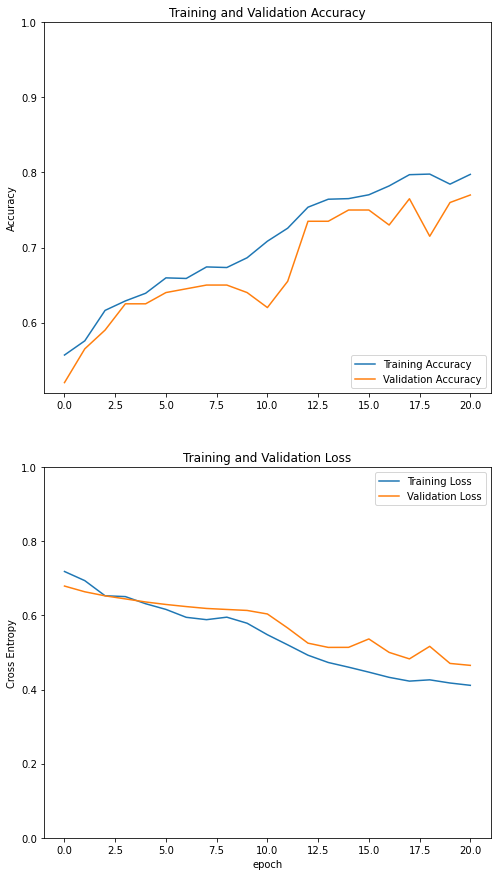

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Means of accuracy
sum_acc = 0
for i in range(len(acc)):
    sum_acc = sum_acc + acc[i]
    acc_mean = sum_acc / len(acc)

sum_val_acc = 0
for i in range(len(val_acc)):
    sum_val_acc = sum_val_acc + val_acc[i]
    val_acc_mean = sum_val_acc / len(val_acc)

print('Mean Validation Accuracy: ' + str(val_acc_mean))
print('Mean Training Accuracy:' + str(acc_mean))

#Means of Loss
sum_loss = 0
for i in range(len(loss)):
    sum_loss = sum_loss + loss[i]
    loss_mean = sum_loss / len(loss)

sum_val_loss = 0
for i in range(len(val_loss)):
    sum_val_loss = sum_val_loss + val_loss[i]
    val_loss_mean = sum_val_loss / len(val_loss)

print('Mean Validation Loss: ' + str(val_loss_mean))
print('Mean Training Loss:' + str(loss_mean))


plt.figure(figsize=(8, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
## Fine Tunning 
base_model.trainable = True ##unfreeze top layers 

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/Users/brunacoimbra/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 10/20
80/80 [==============================] - 177s 2s/step - loss: 0.5479 - accuracy: 0.7084 - val_loss: 0.6039 - val_accuracy: 0.6200
Epoch 11/20
80/80 [==============================] - 212s 3s/step - loss: 0.5206 - accuracy: 0.7258 - val_loss: 0.5660 - val_accuracy: 0.6550
Epoch 12/20
80/80 [==============================] - 183s 2s/step - loss: 0.4926 - accuracy: 0.7537 - val_loss: 0.5252 - val_accuracy: 0.7350
Epoch 13/20
80/80 [==============================] - 192s 2s/step - loss: 0.4730 - accuracy: 0.7644 - val_loss: 0.5137 - val_accuracy: 0.7350
Epoch 14/20
80/80 [==============================] - 178s 2s/step - loss: 0.4604 - accuracy: 0.7652 - val_loss: 0.5138 - val_accuracy: 0.7500
Epoch 15/20
80/80 [==============================] - 200s 2s/step - loss: 0.4470 - accuracy: 0.7703 - val_loss: 0.5365 - val_accuracy: 0.7500
Epoch 16/20
80/80 [==============================] - 144s 2s/step - loss: 0.4329 - accuracy: 0.7821 - val_loss: 0.5002 - val_accuracy: 0.7300
Epoch 

In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


#Means of accuracy
sum_acc = 0
for i in range(len(acc)):
    sum_acc = sum_acc + acc[i]
    acc_mean = sum_acc / len(acc)

sum_val_acc = 0
for i in range(len(val_acc)):
    sum_val_acc = sum_val_acc + val_acc[i]
    val_acc_mean = sum_val_acc / len(val_acc)

print('Mean Validation Accuracy: ' + str(val_acc_mean))
print('Mean Training Accuracy:' + str(acc_mean))

#Means of Loss
sum_loss = 0
for i in range(len(loss)):
    sum_loss = sum_loss + loss[i]
    loss_mean = sum_loss / len(loss)

sum_val_loss = 0
for i in range(len(val_loss)):
    sum_val_loss = sum_val_loss + val_loss[i]
    val_loss_mean = sum_val_loss / len(val_loss)

print('Mean Validation Loss: ' + str(val_loss_mean))
print('Mean Training Loss:' + str(loss_mean))


Mean Validation Accuracy: 0.691249992698431
Mean Training Accuracy:0.7269503567367792
Mean Validation Loss: 0.5552200991660357
Mean Training Loss:0.5133118759840727


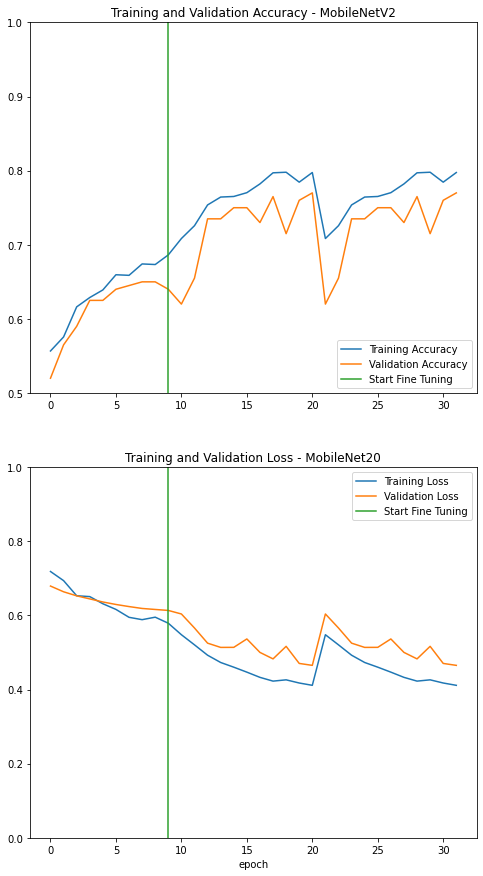

In [40]:
plt.figure(figsize=(8, 15))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy - MobileNetV2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss - MobileNet20')
plt.xlabel('epoch')
plt.show()

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

7/7 [==============================] - 5s 518ms/step - loss: 0.3676 - accuracy: 0.8350
Test accuracy : 0.8349999785423279


Predictions:
 [1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 1]
Labels:
 [1 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1]


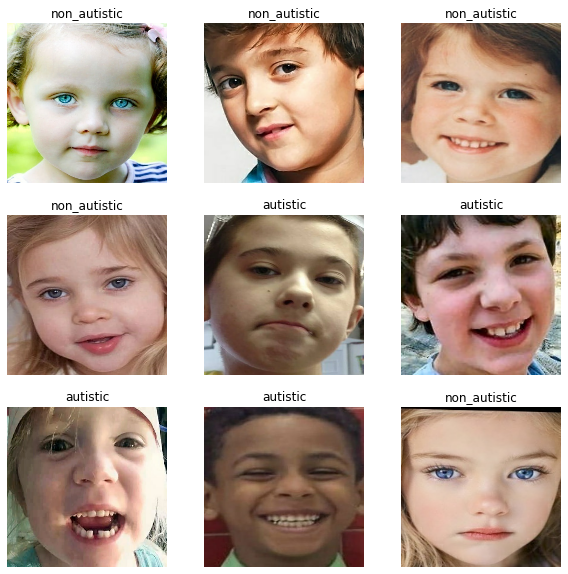

In [34]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")